In [2]:
pip install matplotlib pillow sklearn opencv-python tqdm pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm

2022-09-14 22:38:21.962239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Utility functions

In [23]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model



def build_model_transfer(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model


# Resnet50 - Baseline model

In [16]:
resnet = ResNet50V2(
    include_top=False,
    input_shape=(224,224,3)
)
model = build_model(resnet)
model.summary()

94668760/94668760 [==============================] - 11s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


# Import Data flow

In [3]:
base_path = '/Users/vishnu/Work/uni/VISOPE/deepfake-image-detector/dataset/real_vs_fake/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)
batch_size = 64
train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)
valid_flow = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)
test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


# Preview Dataset

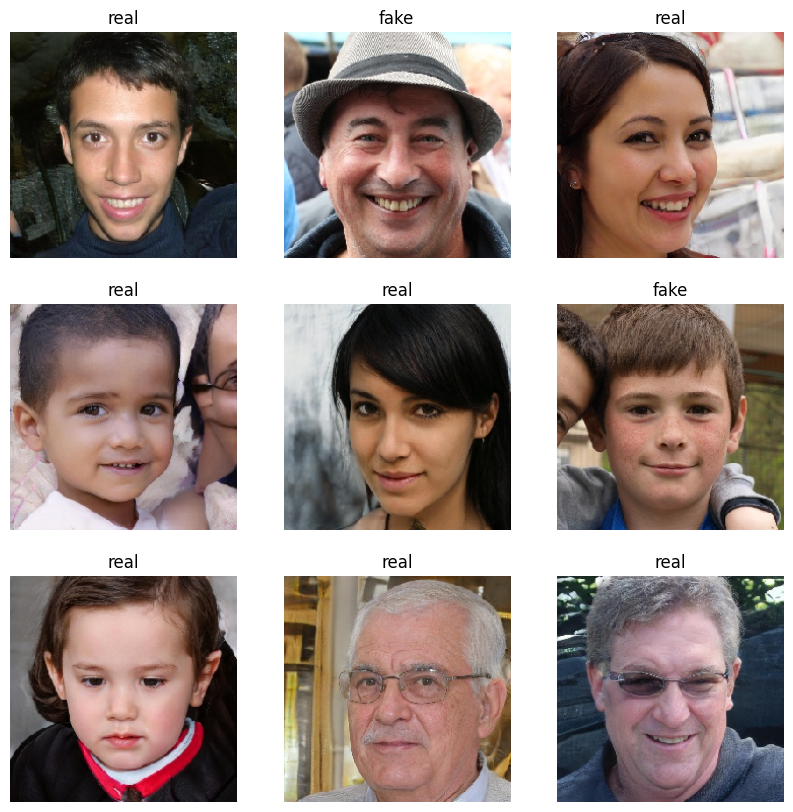

In [6]:
import matplotlib.pyplot as plt

label_arg = {0:'real', 1:'fake'}

plt.figure(figsize=(10, 10))
for images, labels in train_flow:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(label_arg.get(int(labels[i])))
        plt.axis("off")
    break

# Train model

In [18]:
train_steps = 1000//64
valid_steps = 200//64

earlystop_callback = EarlyStopping(monitor='loss', patience=3)
checkpoint_callback = ModelCheckpoint(filepath=f"model.hdf5", 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

history = model.fit(
      train_flow,
      epochs=10,
      steps_per_epoch = train_steps,
      validation_data = valid_flow,
      validation_steps = valid_steps,
      callbacks=[earlystop_callback, checkpoint_callback]
)

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 0.6278 - accuracy: 0.6896
Epoch 1: val_loss improved from inf to 6.83265, saving model to model.hdf5
15/15 [==============================] - 154s 10s/step - loss: 0.6278 - accuracy: 0.6896 - val_loss: 6.8326 - val_accuracy: 0.5312
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.7469 
Epoch 2: val_loss did not improve from 6.83265
15/15 [==============================] - 167s 11s/step - loss: 0.5214 - accuracy: 0.7469 - val_loss: 9.4225 - val_accuracy: 0.5365
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.7698 
Epoch 3: val_loss did not improve from 6.83265
15/15 [==============================] - 173s 12s/step - loss: 0.4958 - accuracy: 0.7698 - val_loss: 8.8826 - val_accuracy: 0.5625
Epoch 4/10
15/15 [==============================] - ETA: 0s - loss: 0.4378 - accuracy: 0.8010 
Epoch 4: val_loss did not improve from 6.83265
15/15 [=====

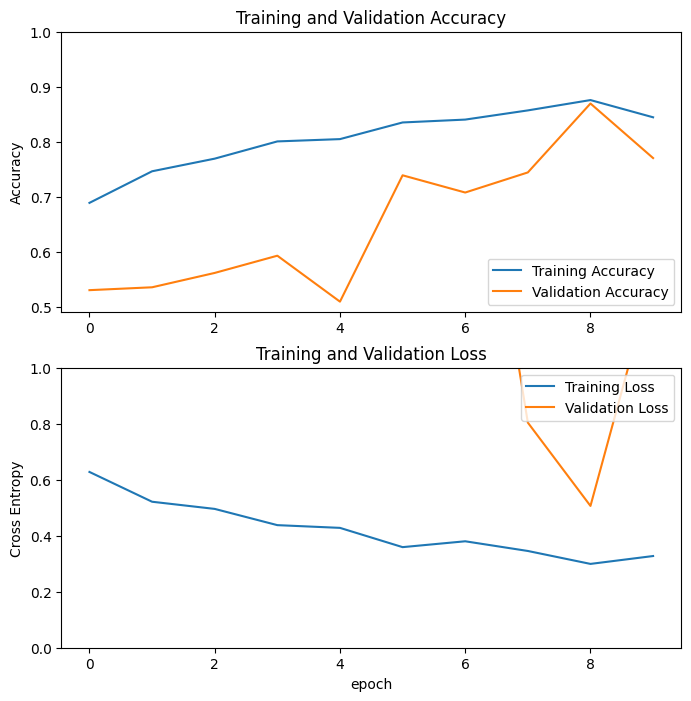

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
y_pred = model.predict(test_flow)
y_test = test_flow.classes

20000/20000 [==============================] - 1741s 87ms/step


In [25]:
from sklearn import metrics

print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))

print("AP Score:", metrics.average_precision_score(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred > 0.5))


ROC AUC Score: 0.90399225
AP Score: 0.8939952897538326
              precision    recall  f1-score   support

           0       0.65      0.96      0.77     10000
           1       0.92      0.47      0.63     10000

    accuracy                           0.72     20000
   macro avg       0.79      0.72      0.70     20000
weighted avg       0.79      0.72      0.70     20000



# Resnet50 - Transfer Learning - Baseline model

In [26]:
resnet.trainable = False
model = build_model_transfer(resnet)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [27]:
history_tf = model.fit(
      train_flow,
      epochs=10,
      steps_per_epoch = train_steps,
      validation_data = valid_flow,
      validation_steps = valid_steps,
      callbacks=[earlystop_callback, checkpoint_callback]
)

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 0.7976 - accuracy: 0.5031
Epoch 1: val_loss did not improve from 0.50640
15/15 [==============================] - 43s 3s/step - loss: 0.7976 - accuracy: 0.5031 - val_loss: 0.6530 - val_accuracy: 0.5729
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.6208
Epoch 2: val_loss did not improve from 0.50640
15/15 [==============================] - 42s 3s/step - loss: 0.6724 - accuracy: 0.6208 - val_loss: 0.6159 - val_accuracy: 0.6458
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 0.6217 - accuracy: 0.6677
Epoch 3: val_loss did not improve from 0.50640
15/15 [==============================] - 47s 3s/step - loss: 0.6217 - accuracy: 0.6677 - val_loss: 0.5989 - val_accuracy: 0.6771
Epoch 4/10
15/15 [==============================] - ETA: 0s - loss: 0.6144 - accuracy: 0.6750
Epoch 4: val_loss did not improve from 0.50640
15/15 [==============================] - 46s 3s/s

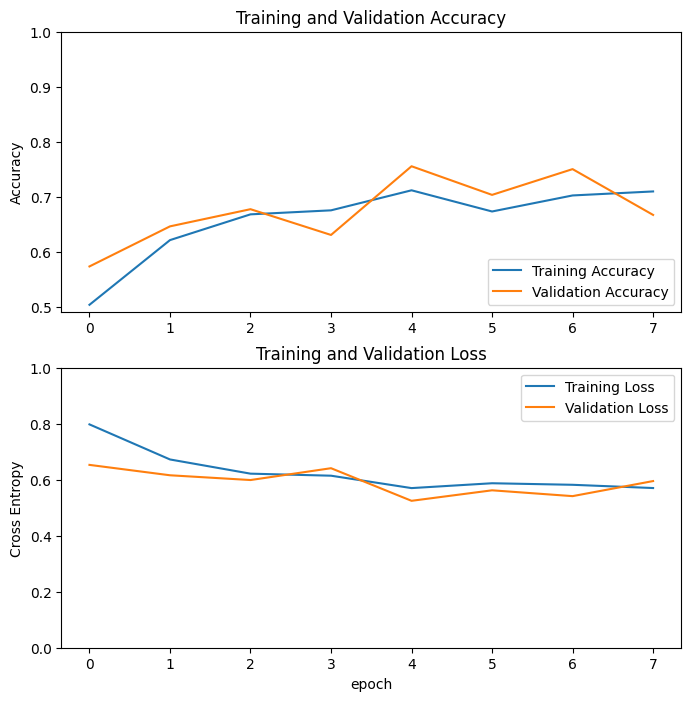

In [30]:
acc = history_tf.history['accuracy']
val_acc = history_tf.history['val_accuracy']

loss = history_tf.history['loss']
val_loss = history_tf.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Resnet50 - Transfer Learning - Fine tuned model

In [40]:
print("Number of layers in the base model: ", len(resnet.layers))

resnet.trainable = True

fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet.layers[:fine_tune_at]:
  layer.trainable = False


model = build_model_transfer(resnet)
model.summary()

Number of layers in the base model:  190
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 15,236,097
Non-trainable params: 8,330,752
_________________________________________________________________


In [41]:
history_tf_ft = model.fit(
      train_flow,
      epochs=10,
      steps_per_epoch = train_steps,
      validation_data = valid_flow,
      validation_steps = valid_steps,
      callbacks=[earlystop_callback, checkpoint_callback]
)

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 0.6320 - accuracy: 0.6792
Epoch 1: val_loss did not improve from 0.50640
15/15 [==============================] - 68s 4s/step - loss: 0.6320 - accuracy: 0.6792 - val_loss: 0.9077 - val_accuracy: 0.6927
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 0.4844 - accuracy: 0.7812
Epoch 2: val_loss did not improve from 0.50640
15/15 [==============================] - 73s 5s/step - loss: 0.4844 - accuracy: 0.7812 - val_loss: 2.3483 - val_accuracy: 0.6302
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 0.4224 - accuracy: 0.8115
Epoch 3: val_loss did not improve from 0.50640
15/15 [==============================] - 68s 5s/step - loss: 0.4224 - accuracy: 0.8115 - val_loss: 5.7929 - val_accuracy: 0.5729
Epoch 4/10
15/15 [==============================] - ETA: 0s - loss: 0.3776 - accuracy: 0.8271
Epoch 4: val_loss did not improve from 0.50640
15/15 [==============================] - 69s 5s/s

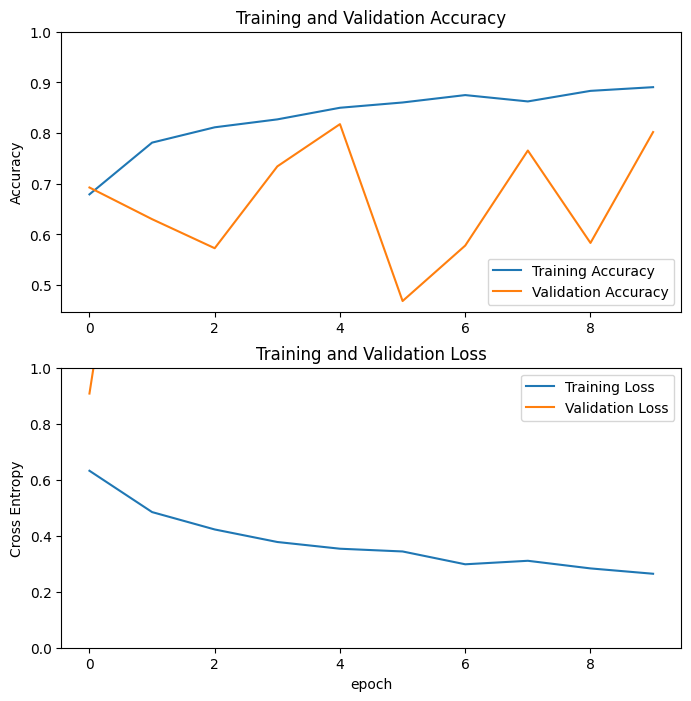

In [42]:
acc = history_tf_ft.history['accuracy']
val_acc = history_tf_ft.history['val_accuracy']

loss = history_tf_ft.history['loss']
val_loss = history_tf_ft.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()